# Data Mining and Visualisation - 2019-2020
Practical 7 - Lower Dimension Representations - Solutions<br>
Teaching Assistant: Muhammad Usman<br>
In this workshop, you will practise using PCA and SVD for problem solving.

# Part 1: Principal Component Analysis (PCA)

PCA is a dimension reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the original set. That sounds cool, you can reduce the features of your data but not retaining the most of the information needed. But if you have tried googling "PCA", you might know that it will give you back the result with all the difficult-sounding terms, such as "Eigenvalue", "Eigenvector", "matrix projection", etc.

In this post, I will not go into too much detail of how PCA is actually calculated but will try to keep it to intuitive level, so that anyone who reads this can understand the underlying concept of it, and implement with Python.

What PCA does is that it transforms the coordinate system so that the axis become the most concise, informative descriptors of our data as a whole.


I found an explanation by Meng Xu's blog (see links below) really intuitive and helps a lot to understand the concept intuitively. 

http://mengnote.blogspot.co.uk/2013/05/an-intuitive-explanation-of-pca.html

The shape you see in figure (A) is on 3 dimensions, but if we focus on the shape of data, not the axis, the shape itself is flat two-dimension surface. By running PCA, we find new coordinates for the data, which will best describe how the data is shaped. The first Principal Component is one that explains the most variance in the data. In figure (B), we see that by drawing the line "Component 1", it is able to retain the information of the most dispersed points of data. And by adding the line "Component 2", this "Component 2" line explains the second most variance in our data. The next step is to transform the original data onto our new found axis which is just two instead of original three dimensions. The final result in figure (C) gives us a pretty good picture of how the data is shaped only with two dimensions even though we have discarded the third dimension.



    
And eigenvectors and eigenvalues are used when implementing this transformation of the data. An eigenvector specifies a direction through the original coordinate space, while eigenvalues indicate the amount of variance in the direction of its corresponding eigenvector.

If you want to dive deeper into the concept of PCA, there are some more blog posts I found useful.
- A blog post by Victor Powell: "Principal Component Analysis" (You can manipulate and play around with data points in 2d or 3d that will help you enormously to have an intuitive understanding of what PCA does)
http://setosa.io/ev/principal-component-analysis/
- A blog post by George Dallas: "Principal Component Analysis 4 Dummies: Eigenvectors, Eigenvalues and Dimension Reduction" (he has successfully explained the concept without a single math formula, unbelievable)
https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/

#### Summarizing the PCA approach
Listed below are the 6 general steps for performing a principal component analysis, which we will investigate in the following sections.

1, Take the whole dataset consisting of $d$-dimensional samples ignoring the class labels

2, Compute the $d$-dimensional mean vector (i.e., the means for every dimension of the whole dataset)

3, Compute the scatter matrix (alternatively, the covariance matrix) of the whole data set

4, Compute eigenvectors ($\pmb e_1, \; \pmb e_2, \; ..., \; \pmb e_d $) and corresponding eigenvalues ($\pmb \lambda_1, \; \pmb \lambda_2, \; ..., \; \pmb \lambda_d$)

5, Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $d \times k $ dimensional matrix $\pmb W\;$(where every column represents an eigenvector)

6, Use this $d \times k $ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $\pmb y = \pmb W^T \times \pmb x$ (where $\pmb x$ is a $d \times 1$-dimensional vector representing one sample, and $\pmb y$ is the transformed $k \times 1$-dimensional sample in the new subspace.)

We will be using the Wine dataset from The UCI Machine Learning Repository in our example. This dataset consists of 178 wine samples with 13 features describing their different chemical properties. You can find out more here.

In this section we will tackle the first four steps of a PCA; later we will go over the last three. We will start by loading the Wine dataset directly from the repository:

In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Next, we will process the Wine data into separate training and test sets — using a 70:30 split — and standardize it to unit variance. Feature scaling through standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. See more explanations in the link
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split into training and testing sets
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3,
    stratify=y, random_state=0
)
# standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

After completing the mandatory preprocessing, let’s advance to the second step: constructing the covariance matrix. The symmetric d x d-dimensional covariance matrix, where d is the number of dimensions in the dataset, stores the pairwise covariances between the different features. For example, the covariance between two features $x_j$ and $x_k$ on the population level can be calculated via the following equation:

 $\quad\pmb{\sigma_{jk}} = $ $\frac{1}{n}\sum_i^j (x_j^{(i)}-u_j)(x_k^{(i)}-u_k)\quad$
 
Here, $u_j$ and $u_k$ are the sample means of features j and k, respectively.

Note that the sample means are zero if we standardized the dataset. A positive covariance between two features indicates that the features increase or decrease together, whereas a negative covariance indicates that the features vary in opposite directions. For example, the covariance matrix of three features can then be written as follows (note that Σ stands for the Greek uppercase letter sigma, which is not to be confused with the sum symbol):

 $\quad\pmb{\Sigma} = $
 $\begin{bmatrix}\sigma_1^2\quad \sigma_{12}\quad \sigma_{13}\\\sigma_{21}\quad \sigma_2^2\quad\sigma_{23}\\\sigma_{31}\quad\sigma_{32}\quad \sigma_3^2\end{bmatrix}\quad$ (covariance matrices)
 
 The eigenvectors of the covariance matrix represent the principal components (the directions of maximum variance), whereas the corresponding eigenvalues will define their magnitude. In the case of the Wine dataset, we would obtain 13 eigenvectors and eigenvalues from the 13 x 13-dimensional covariance matrix.

Now, for our third step, let’s obtain the eigenpairs of the covariance matrix. An eigenvector v satisfies the following condition:

   $\quad \Sigma v =\lambda v$

Here, λ is a scalar: the eigenvalue. Since the manual computation of eigenvectors and eigenvalues is a somewhat tedious and elaborate task, we will use the linalg.eig function from NumPy to obtain the eigenpairs of the Wine covariance matrix:

In [3]:
import numpy as np

cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

Using the numpy.cov function, we computed the covariance matrix of the standardized training dataset. Using the linalg.eig function, we performed the eigendecomposition, which yielded a vector (eigen_vals) consisting of 13 eigenvalues and the corresponding eigenvectors stored as columns in a 13 x 13-dimensional matrix (eigen_vecs).

#### Total and Explained Variance

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance). The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude; we are interested in the top k eigenvectors based on the values of their corresponding eigenvalues.

But before we collect those k most informative eigenvectors, let’s plot the variance explained ratios of the eigenvalues. The variance explained ratio of an eigenvalue $\lambda_j$ is simply the fraction of an eigenvalue $\lambda_j$ and the total sum of the eigenvalues:

$\frac{\lambda_j}{\sum_{j=1}^d \lambda_j}$

Using the NumPy cumsum function, we can then calculate the cumulative sum of explained variances, which we will then plot via matplotlib’s step function:

In [4]:
import matplotlib.pyplot as plt

# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.bar(range(1,14), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 1 Axes>

The resulting plot indicates that the first principal component alone accounts for approximately 40% of the variance. Also, we can see that the first two principal components combined explain almost 60% of the variance in the dataset.

#### Feature Transformation

After we have successfully decomposed the covariance matrix into eigenpairs, let’s now proceed with the last three steps of PCA to transform the Wine dataset onto the new principal component axes.

We will sort the eigenpairs by descending order of the eigenvalues, construct a projection matrix from the selected eigenvectors, and use the projection matrix to transform the data onto the lower-dimensional subspace.

We start by sorting the eigenpairs by decreasing order of the eigenvalues:

In [5]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

Next, we collect the two eigenvectors that correspond to the two largest eigenvalues, to capture about 60% of the variance in this dataset. Note that we only chose two eigenvectors for the purpose of illustration, since we are going to plot the data via a two-dimensional scatter plot later in this subsection. In practice, the number of principal components has to be determined by a trade-off between computational efficiency and the performance of the classifier:

In [6]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


By executing the preceding code, we have created a 13 x 2-dimensional projection matrix W from the top two eigenvectors.

Using the projection matrix, we can now transform a sample x (represented as a 1 x 13-dimensional row vector) onto the PCA subspace (the principal components one and two) obtaining x′, now a two-dimensional sample vector consisting of two new features:

$x'=W^Tx$

In [7]:
X_train_pca = X_train_std.dot(w)

Lastly, let’s visualize the transformed Wine training set, now stored as an 124 x 2-dimensional matrix, in a two-dimensional scatterplot:

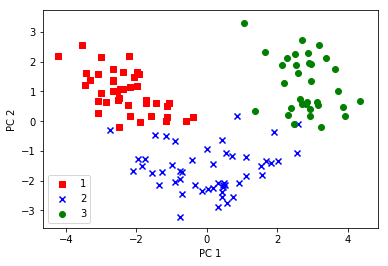

In [8]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

As we can see in the resulting plot, the data is more spread along the x-axis — the first principal component — than the second principal component (y-axis), which is consistent with the explained variance ratio plot that we created previously. However, we can intuitively see that a linear classifier will likely be able to separate the classes well.

Although we encoded the class label information for the purpose of illustration in the preceding scatter plot, we have to keep in mind that PCA is an unsupervised technique that does not use any class label information.

#### PCA in scikit-learn

Although the verbose approach in the previous subsection helped us to follow the inner workings of PCA, we will now discuss how to use the PCA class implemented in scikit-learn. The PCA class is another one of scikit-learn’s transformer classes, where we first fit the model using the training data before we transform both the training data and the test dataset using the same model parameters.

Let’s use the PCA class on the Wine training dataset, classify the transformed samples via logistic regression:

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# intialize pca and logistic regression model
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='auto', solver='liblinear')

# fit and transform data
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [10]:
Now, using a custom plot_decision_regions function, we will visualize the decision regions:

SyntaxError: invalid syntax (<ipython-input-10-7dedd47019b9>, line 1)

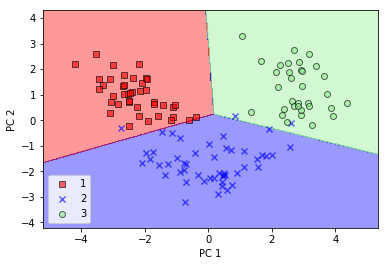

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)# plot decision regions for training set


plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

By executing the preceding code, we should now see the decision regions for the training data reduced to two principal component axes.

For the sake of completeness, let’s plot the decision regions of the logistic regression on the transformed test dataset as well to see if it can separate the classes well:

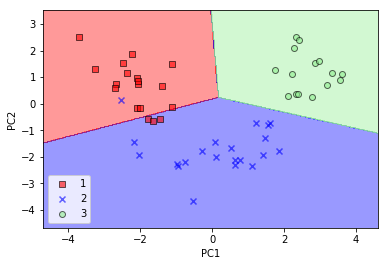

In [12]:
# plot decision regions for test set
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

After we plotted the decision regions for the test set by executing the preceding code, we can see that logistic regression performs quite well on this small two-dimensional feature subspace and only misclassifies very few samples in the test dataset.

If we are interested in the explained variance ratios of the different principal components, we can simply initialize the PCA class with the n_components parameter set to None, so all principal components are kept and the explained variance ratio can then be accessed via the explained_variance_ratio_ attribute:

In [13]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

Note that we set n_components=None when we initialized the PCA class so that it will return all principal components in a sorted order instead of performing a dimensionality reduction.

## Exercise 1: PCA for  USDA National Nutrient Dataset

Your task is to execute PCA on a dataset derived from the USDA National Nutrient Database. The dataset can be downloaded from blackboard. Your task involves the following steps: 

1, load the dataset

2, remove highly correlated features (we have done this for you)

3, normalise the dataset 

4, apply PCA on the dataset

5, find most important components

6, try to interpret the first 5 most important compenents

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [16]:
# read data

df = pd.read_csv('nndb_flat.csv',header=0)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8618 entries, 0 to 8617
Data columns (total 45 columns):
ID                  8618 non-null int64
FoodGroup           8618 non-null object
ShortDescrip        8618 non-null object
Descrip             8618 non-null object
CommonName          1063 non-null object
MfgName             1560 non-null object
ScientificName      732 non-null object
Energy_kcal         8618 non-null float64
Protein_g           8618 non-null float64
Fat_g               8618 non-null float64
Carb_g              8618 non-null float64
Sugar_g             8618 non-null float64
Fiber_g             8618 non-null float64
VitA_mcg            8618 non-null float64
VitB6_mg            8618 non-null float64
VitB12_mcg          8618 non-null float64
VitC_mg             8618 non-null float64
VitE_mg             8618 non-null float64
Folate_mcg          8618 non-null float64
Niacin_mg           8618 non-null float64
Riboflavin_mg       8618 non-null float64
Thiamin_mg          

#### Check for highly correlated features

You can use the corr method in Pandas dataframe to perform pairwise correlation of columns, columns that are highly correlated (correlation >0.9) should be removed. The following code helps you to identify the highly correlated features

In [17]:
# find highly correlated columns

used = []
corrs = []
for i, j in enumerate(df.corr().columns):
    for k in range(len(df.corr())):
        if ((df.corr().iloc[k, i] > 0.9) & 
            (j not in used) &
            (j != df.corr().index[k])):
            
            used.append(j)
            corrs.append((j, df.corr().index[k], 
                          np.round(df.corr().iloc[k, i], 2)))

            
corrsdf = pd.DataFrame([[i[0] for i in corrs],
                        [i[1] for i in corrs],
                        [i[2] for i in corrs]])

corrsdf = corrsdf.T.rename(columns = {0:'column',1:'row',2:'corr'})
corrsdf[:15]

,column,row,corr
0,VitA_mcg,VitA_USRDA,1
1,VitB6_mg,VitB6_USRDA,1
2,VitB12_mcg,VitB12_USRDA,1
3,VitC_mg,VitC_USRDA,1
4,VitE_mg,VitE_USRDA,1
5,Folate_mcg,Folate_USRDA,1
6,Niacin_mg,Niacin_USRDA,1
7,Riboflavin_mg,Riboflavin_USRDA,1
8,Thiamin_mg,Thiamin_USRDA,1
9,Calcium_mg,Calcium_USRDA,1


You can see that the "_USRDA" features are redundant. They should be removed

In [18]:
# remove the "_USRDA" features
df.drop(df.columns[df.columns.str.contains('_USRDA')].values, 
        inplace=True, axis=1)

In [19]:
# Remove non-numeric features
df.set_index('ID', inplace=True)
df_desc = df.iloc[:, :6]
df.drop(df.columns[:6].values, axis=1, inplace=True)

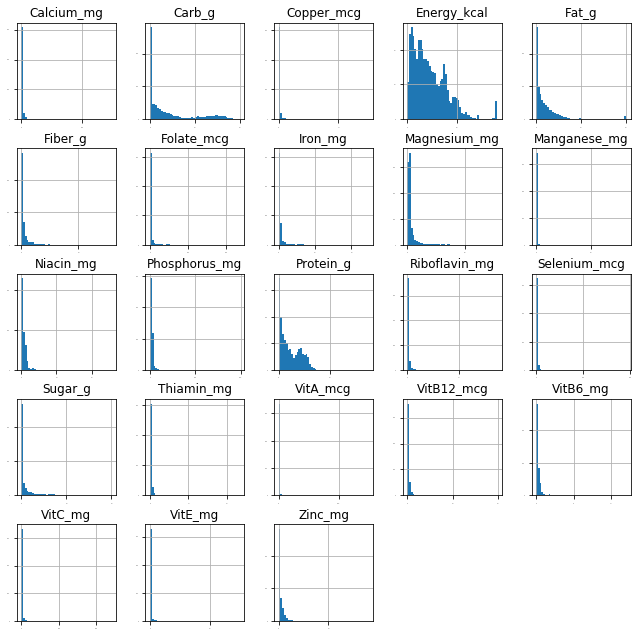

In [20]:
ax = df.hist(bins=50, xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

Most of the variables are "zero" inflated and skewed right. We may want to consider transformation so "improve" the distributions and hopefully produce better correlations for our PCA. Note: this is an optional step that may not always improve results.


In [22]:
from scipy.stats import boxcox
# add 1 because data must be positive (we have many zeros)
df = df + 1
df_TF = pd.DataFrame(index=df.index)
for i in df.columns.values:
    df_TF["%s_TF" % i] = boxcox(df.loc[:, i])[0]

In [24]:
# you can normalise the original data if you do not use tranformation
# df_norm = StandardScaler().fit_transform(df) 
df_norm = StandardScaler().fit_transform(df_TF) 

print("mean: ", np.round(df_norm.mean(), 2))
print("standard dev: ", np.round(df_norm.std(), 2))

mean:  0.0
standard dev:  1.0


##### Implement PCA

In [25]:
# from sklearn.decomposition import PCA
fit = PCA()
pca = fit.fit_transform(df_norm)
pca

array([[-2.63841405e+00, -1.70251245e+00,  1.28372455e+00, ...,
         1.20971417e-01, -1.93807125e-02, -9.00855599e-01],
       [-2.53793117e+00, -1.55046401e+00,  1.27981556e+00, ...,
         2.68506480e-01,  3.62586666e-03, -8.95689899e-01],
       [-3.75133548e+00, -2.08018978e+00,  2.06793168e+00, ...,
        -1.62701828e-01, -3.22116614e-02, -9.97154120e-01],
       ...,
       [-3.28860010e+00,  6.89373532e-01,  1.81022922e+00, ...,
         5.11991014e-01, -3.50434510e-01, -5.61815386e-01],
       [ 1.78153849e+00, -7.35900960e-01, -1.99994641e+00, ...,
         1.12915685e+00, -7.90341239e-01,  3.83494452e-01],
       [ 1.21057434e+00, -1.20474083e+00, -2.16951015e+00, ...,
         1.66434007e-01, -6.90435951e-01, -4.67142120e-01]])

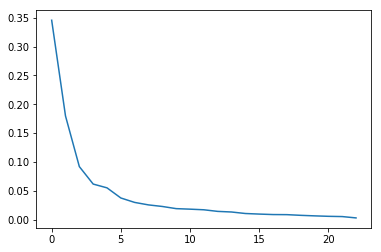

In [26]:
# check the eigenvalues to find most important components

plt.plot(fit.explained_variance_ratio_)

In [27]:
# find the first nc eigenvectors that account for 90% of the variance


nc=1
for i in range(len(fit.explained_variance_ratio_)):
    tmpSum=fit.explained_variance_ratio_[:i].sum()
    if tmpSum>=0.9:
        print(i, tmpSum)
        nc=i
        break

12 0.9051581893080729


In [28]:
# we see that the nc vectors are orthogonal

pca = pd.DataFrame(pca[:, :nc], index=df.index)
pca = pca.join(df_desc)
pca.drop(['CommonName','MfgName','ScientificName'], axis=1, inplace=True)
pca.rename(columns={i: 'c'+str(i+1) for i in range(nc)}, inplace=True)

np.round(pca.corr(), nc)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12
c1,1.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0
c2,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0
c3,-0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
c4,-0.0,-0.0,0.0,1.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0
c5,0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
c6,0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,0.0,-0.0
c7,-0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0
c8,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,0.0
c9,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0
c10,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0


## Try to interpret the components

(this is where deep subject matter expertise, in this case nutrition, comes in handy)


**Component one** 

foods that are high in: zinc, and other vitamins and minerals

low in: fat, sugar

In [29]:
vects = fit.components_[:nc]

one = pd.Series(vects[0], index=df.columns)
one.sort_values(ascending=False)

Zinc_mg          0.308506
Phosphorus_mg    0.305000
Niacin_mg        0.294094
Protein_g        0.286086
Riboflavin_mg    0.282687
VitB6_mg         0.270646
Selenium_mcg     0.264114
Iron_mg          0.262314
Magnesium_mg     0.260245
Thiamin_mg       0.235440
VitB12_mcg       0.221322
Copper_mcg       0.220232
Folate_mcg       0.167856
Energy_kcal      0.165126
Fat_g            0.161488
Calcium_mg       0.135512
VitE_mg          0.090808
Manganese_mg     0.088762
VitA_mcg         0.056996
Fiber_g         -0.004663
Carb_g          -0.033767
VitC_mg         -0.069830
Sugar_g         -0.076132
dtype: float64

# Part 2: Singular Value Decomposition and Applications

The singular value decomposition of a matrix has many applications. Here I'll focus on an introduction to singular value decomposition and an application in clustering articles by topic. In another notebook (<a href="http://nbviewer.ipython.org/gist/frankcleary/4d2bd178708503b556b0">link</a>) I show how singular value decomposition can be used in image compression.

Any matrix $A$ can be decomposed to three matrices $U$, $\Sigma$, and $V$ such that $A = U \Sigma V$, this is called singular value decomposition. The columns of $U$ and $V$ are orthonormal and $\Sigma$ is diagonal. Most scientific computing packages have a function to compute the singular value decomposition, I won't go into the details of how to find $U$, $\Sigma$ and $V$ here. Some sources write the decomposition as $A = U \Sigma V^T$, so that their $V^T$ is our $V$. The usage in this notebook is consistent with how numpy's singular value decomposition function returns $V$.

## Example with a small matrix $A$:

If $A = \begin{bmatrix} 1 & 0 \\ 1 & 2 \end{bmatrix}$
                     
$A$ can be written as $U \Sigma V$ where $U$, $\Sigma$, and $V$ are, rounded to 2 decimal places:

$U = \begin{bmatrix} -0.23 & -0.97 \\ -0.97 & 0.23 \end{bmatrix}$
                     
$S = \begin{bmatrix} 2.29 & 0 \\ 0 & 0.87 \end{bmatrix}$
                     
$V = \begin{bmatrix} -0.53 & -0.85 \\ -0.85 & 0.53 \end{bmatrix}$

# Interpretation

Although the singular value decomposition has interesting properties from a linear algebra standpoint, I'm going to focus here on some of its applications and skip the derivation and geometric interpretations.

Let $A$ be a $m \times n$ matrix with column vectors $\vec{a}_1, \vec{a}_2, ..., \vec{a}_n$. In the singular value decomposition of $A$, $U$ will be $m \times m$, $\Sigma$ will be $m \times n$ and $V$ will be $n \times n$. We denote the column vectors of $U$ as $\vec{u}_1, \vec{u}_2, ..., \vec{u}_m$ and $V$  as $\vec{v}_1, \vec{v}_2, ..., \vec{v}_n$, similarly to $A$. We'll call the values along the diagonal of $\Sigma$ as $\sigma_1, \sigma_2, ...$.

We have that $A = U \Sigma V$ where:

$U = \begin{bmatrix} \\ \\ \\ \vec{u}_1 & \vec{u}_2 & \dots & \vec{u}_m \\ \\ \\ \end{bmatrix}$

$\Sigma = \begin{bmatrix} \sigma_1 & 0 & \dots \\ 0 &  \sigma_2 & \dots \\ \vdots & \vdots & \ddots \end{bmatrix}$

$V = \begin{bmatrix} \\ \\ \\ \vec{v}_1 & \vec{v}_2 & \dots & \vec{v}_n \\ \\ \\ \end{bmatrix}$

Because $\Sigma$ is diagonal, the columns of $A$ can be written as:

$\vec{a}_i = \vec{u}_1 * \sigma_1 * V_{1,i} + 
             \vec{u}_2 * \sigma_2 * V_{2,i} + ... = U * \Sigma * \vec{v}_i$
             
This is equivalent to creating a vector $\vec{w}_i$, where the elements of $\vec{w}_i$ are the elements of $\vec{v}_i$, weighted by the $\sigma$'s:

$\vec{w}_i = \begin{bmatrix} \sigma_1V_{1,i} \\ \sigma_2V_{2,i} \\
           \sigma_3V_{3,i} \\ \vdots \end{bmatrix} = \Sigma * \vec{v}_i$
           
Then $\vec{a}_i = U * \vec{w}_i$. That is to say that every column $\vec{a}_i$ of $A$ is expressed by a sum over all the columns of $U$, weighted by the values in the $i^{th}$ column of $V$, and the $\sigma$'s. By convention the order of the columns in $U$ and rows in $V$ is chosen such that the values in 
$\Sigma = \begin{bmatrix} \sigma_1 & 0 & \dots \\ 0 &  \sigma_2 & \dots \\ \vdots & \vdots & \ddots \end{bmatrix}$ obey $\sigma_1 > \sigma_2 > \sigma_3 > ...$. This means that as a whole, the first column of $U$ and the first row of $V$ contribute more to the final values of $A$ than subsequent columns. This has applications in image compression (<a href="http://nbviewer.ipython.org/gist/frankcleary/4d2bd178708503b556b0">link to another notebook</a>) and reducing the dimensionality of data by selecting the most import components.

## Brief discussion of dimensionality

This section isn't required to understand how singular value decomposition is useful, but I've included it for completeness.

If $A$ is $m \times n$ ($m$ rows and $n$ columns), $U$ will be $m \times m$, $\Sigma$ will be $m \times n$ and $V$ will be $n \times n$. However, there are only $r = rank(A)$ non-zero values in $\Sigma$, i.e. $\sigma_1, ..., \sigma_r \neq 0$; $\sigma_{r+1}, ..., \sigma_n = 0$. Therefore columns of $U$ beyond the $r^{th}$ column and rows of $V$ beyond the $r^{th}$ row do not contribute to $A$ and are usually omitted, leaving $U$ an $m \times r$ matrix, $\Sigma$ an $r \times r$ diagonal matrix and $V$ an $r \times n$ matrix.



## Example with data:

Singular value decomposition can be used to classify similar objects (for example, news articles on a particular topic). Note above that similar $\vec{a_i}$'s will have similar $\vec{v_i}$'s.

Imagine four blog posts, two about skiing and two about hockey. I've made up some data about five different words and the number of times they appear in each post:

In [30]:
import pandas as pd

c_names = ['post1', 'post2', 'post3', 'post4']
words = ['ice', 'snow', 'tahoe', 'goal', 'puck']
post_words = pd.DataFrame([[4, 4, 6, 2],
                           [6, 1, 0, 5],
                           [3, 0, 0, 5],
                           [0, 6, 5, 1],
                           [0, 4, 5, 0]],
                          index = words,
                          columns = c_names)
post_words.index.names = ['word:']
post_words

,post1,post2,post3,post4
word:,,,,
ice,4,4,6,2
snow,6,1,0,5
tahoe,3,0,0,5
goal,0,6,5,1
puck,0,4,5,0


It looks like posts 1 and 4 pertain to skiing, and while posts 2 and 3 are about hockey.

Imagine the DataFrame <code>post_words</code> as the matrix $A$, where the entries represent the number of times a given word appears in the post. The singular value decomposition of $A$ can be calculated using numpy.

In [32]:
import numpy as np

U, sigma, V = np.linalg.svd(post_words)
print("V = ")
print(np.round(V, decimals=2))

V = 
[[-0.4  -0.57 -0.63 -0.35]
 [-0.6   0.33  0.41 -0.6 ]
 [ 0.6  -0.41  0.32 -0.61]
 [-0.34 -0.63  0.58  0.39]]


Recall that $\vec{a}_i = U * \Sigma * \vec{v}_i$, that is each column $\vec{v}_i$ of $V$ defines the entries in that column, $\vec{a}_i$, of our data matrix, $A$. Let's label V with the identities of the posts using a DataFrame:

In [33]:
V_df = pd.DataFrame(V, columns=c_names)
V_df

,post1,post2,post3,post4
0,-0.395634,-0.570869,-0.630100,-0.347212
1,-0.599836,0.331743,0.408279,-0.602870
2,0.604001,-0.405353,0.321932,-0.605996
3,-0.344752,-0.632253,0.576751,0.385695


Note how post1 and post4 agree closely in value in the first two rows of $V$, as do post2 and post3. This indicates that posts 1 and 4 contain similar words (in this case words relating to skiing). However, the agreement is less close in the last two rows, even among related posts. This is because the weights of the last two rows, $\sigma_3$ and $\sigma_4$, are small compared to $\sigma_1$ and $\sigma_2$. Let's look at the values for the $\sigma$'s.

In [34]:
sigma

array([13.3221948 ,  9.2609512 ,  2.41918664,  1.37892883])

$\sigma_1$ and $\sigma_2$ are about an order of magnitude greater than $\sigma_3$ and $\sigma_4$, indicating that the values in the first two rows of $V$ are much more important than the values in the last two. In fact we could closely reproduce $A$ using just the first two rows of $V$ and first two columns of $U$, with an error of at most 1 word:

In [36]:
A_approx = np.matrix(U[:, :2]) * np.diag(sigma[:2]) * np.matrix(V[:2, :])

print("A calculated using only the first two components:\n")
print(pd.DataFrame(A_approx, index=words, columns=c_names))
print("\nError from actual value:\n")
print(post_words - A_approx)

A calculated using only the first two components:

          post1     post2     post3     post4
ice    3.197084  4.818556  5.325736  2.792675
snow   5.619793  0.588201  0.384675  5.412204
tahoe  4.043943  0.071665 -0.123639  3.917015
goal   0.682117  5.089628  5.762122  0.336491
puck   0.129398  4.219523  4.799185 -0.143946

Error from actual value:

          post1     post2     post3     post4
word:                                        
ice    0.802916 -0.818556  0.674264 -0.792675
snow   0.380207  0.411799 -0.384675 -0.412204
tahoe -1.043943 -0.071665  0.123639  1.082985
goal  -0.682117  0.910372 -0.762122  0.663509
puck  -0.129398 -0.219523  0.200815  0.143946


To help visualize the similarity between posts, $V$ can be displayed as an image. Notice how the similar posts (1 and 4, 2 and 3) have similar color values in the first two rows:

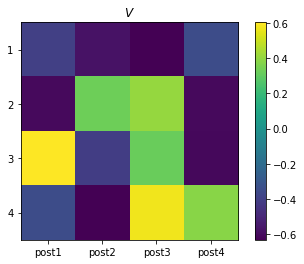

In [39]:
import matplotlib.pyplot as plt

plt.imshow(V, interpolation='none')
plt.xticks(range(len(c_names)))
plt.yticks(range(len(words)))
plt.ylim([len(words) - 1.5, -.5])
ax = plt.gca()
ax.set_xticklabels(c_names)
ax.set_yticklabels(range(1, len(words) + 1))
plt.title("$V$")
plt.colorbar();

Another thing the singular value decomposition tells us is what most defines the different categories of posts. The skiing posts have very different values from the hockey posts in the second row of $V$, i.e. $V_{2,1} \approx V_{2, 4}$ and $V_{2,2} \approx V_{2, 3}$ but $V_{2,1} \neq V_{2, 2}$.

Recall from above that:

$\vec{a}_i = \vec{u}_1 * \sigma_1 * V_{1,i} + 
             \vec{u}_2 * \sigma_2 * V_{2,i} + ...$
             
Thus the posts differ very much in how much the values in $\vec{u}_2$ contribute to their final word count. Here is $\vec{u}_2$:

In [40]:
pd.DataFrame(U[:,1], index=words)

,0
ice,0.018526
snow,-0.678291
tahoe,-0.519801
goal,0.370263
puck,0.363717


From this we can conclude that, at least in this small data set, the words 'snow' and 'tahoe' identify a different class of posts from the words 'goal' and 'puck'.

## Excercise 2: Dimensionality reduction on imgae dataset using using singular value decomposition

You are given a set of images of human faces (please download from blackboard). These images contain 32 X 32 pixels in grayscale, resulting in a dimension of 1,024 features and your task is to reduce the dimension to around 100 most prominent features that best describe our data. Then, using these re


In [41]:
# import modules
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

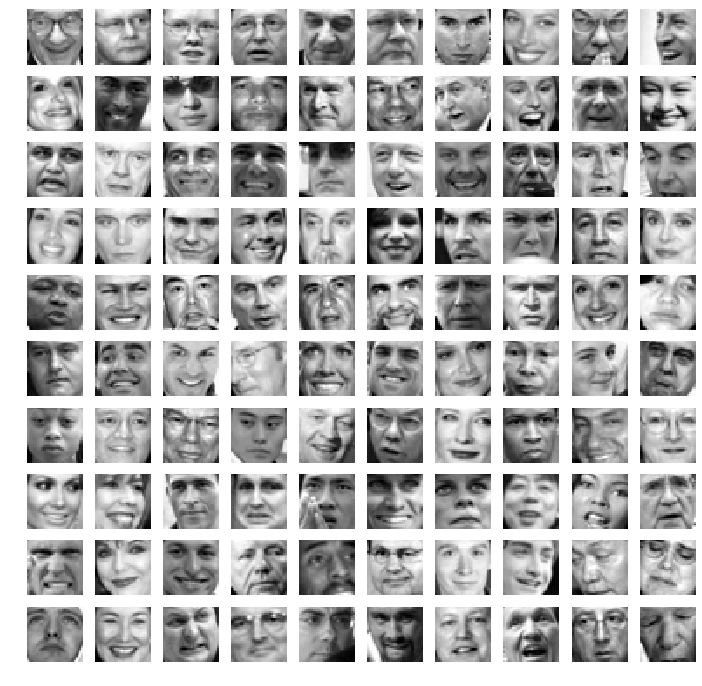

In [42]:
# load dataset
mat = loadmat("faces.mat")
X = mat["X"]

# plot 100 faces
fig, ax = plt.subplots(nrows=10,ncols=10,figsize=(12,12))
for i in range(0,100,10):
    for j in range(10):
        ax[int(i/10),j].imshow(X[i+j,:].reshape(32,32,order="F"),cmap="gray")
        ax[int(i/10),j].axis("off")
plt.show()

In [43]:
# apply SVD to the matrix X
U, sigma, V = np.linalg.svd(X)

# Reconstruct the data using only the first 100 vectors
n=100
Y = np.matrix(U[:, :n]) * np.diag(sigma[:n]) * np.matrix(V[:n, :])

In [ ]:
# plot the reconstructed 100 faces

fig2, ax2 = plt.subplots(10,10,figsize=(12,12))
for i in range(0,100,10):
    for j in range(10):
        ax2[int(i/10),j].imshow(Y[i+j,:].reshape(32,32,order="F"),cmap="gray")
        ax2[int(i/10),j].axis("off")
plt.show()